# 1.   Setup
*   First we will import the necessary libraries as well as the data












In [ ]:
import pandas as pd               # for handling data
import numpy as np                # for large arrays and matrices
import matplotlib.pyplot as plt   # for plotting data
import seaborn as sns             # for statistical graphics
import xgboost as xgb             # for machine learning

The CSV file was generated from this https://github.com/pvicks585/NFL-WebScrape/blob/main/Webscraping%20NFL%20Player%20Data.ipynb GitHub repo created by user pvicks585. It scrapes the data from https://www.pro-football-reference.com/


In [ ]:
#import the data from https://www.pro-football-reference.com/
df = pd.read_csv('2023playerstats.csv')

In [ ]:
# prompt: show the head of the data in df

df.head()


,Unnamed: 0,Player,Tm,FantPos,Age,G,GS,Cmp,Att,Yds,...,2PM,2PP,FantPt,PPR,DKPt,FDPt,VBD,PosRank,OvRank,Year
0,0,Christian McCaffrey*+,SFO,RB,27,16,16,0.0,0.0,0.0,...,NaN,NaN,324.0,391.3,399.3,357.8,157.0,1,1.0,2023
1,1,CeeDee Lamb*+,DAL,WR,24,17,17,0.0,0.0,0.0,...,1.0,NaN,268.0,403.2,411.2,335.7,131.0,1,2.0,2023
2,2,Josh Allen,BUF,QB,27,17,17,385.0,579.0,4306.0,...,NaN,3.0,393.0,392.6,420.6,410.6,122.0,1,3.0,2023
3,3,Tyreek Hill*+,MIA,WR,29,16,16,0.0,0.0,0.0,...,NaN,NaN,257.0,376.4,380.4,316.9,120.0,2,4.0,2023
4,4,Jalen Hurts*,PHI,QB,25,17,17,352.0,538.0,3858.0,...,NaN,NaN,357.0,356.8,382.8,371.8,89.0,2,5.0,2023


# 2.   Clean Up Data
*   Remove uneccesary features
*   Rename and differentiate duplicates (i.e. Yds -> Rush Yds, Rec. Yds, and Pass Yds)
*   Trim observations down to 200 (200 most fantasy-relavant players)
*   Set null values to 0 (YPC and YPR for some positions)

In [ ]:
df.columns

Index(['Unnamed: 0', 'Player', 'Tm', 'FantPos', 'Age', 'G', 'GS', 'Cmp', 'Att',
       'Yds', 'TD', 'Int', 'Att.1', 'Yds.1', 'Y/A', 'TD.1', 'Tgt', 'Rec',
       'Yds.2', 'Y/R', 'TD.2', 'Fmb', 'FL', 'TD.3', '2PM', '2PP', 'FantPt',
       'PPR', 'DKPt', 'FDPt', 'VBD', 'PosRank', 'OvRank', 'Year'],
      dtype='object')

In [ ]:
# Drop all columns we don't want
df = df.drop(columns=['Unnamed: 0', 'Player', 'Tm', 'Age', 'G', 'GS', 'FL', 'TD.3', '2PM', '2PP', 'FantPt', 'PPR', 'DKPt', 'FDPt', 'VBD', 'PosRank', 'OvRank', 'Year'])

# Rename columns with specific names
df = df.rename(columns={'FantPos': 'Position', 'Cmp': 'Passes Completed', 'Att': 'Passes Attempted', 'Yds': 'Passing Yards', 'TD': 'Passing Touchdowns',
                        'Int': 'Interceptions', 'Att.1': 'Rushing Attempts', 'Yds.1': 'Rushing Yards', 'Y/A': 'Rushing Yards per Attempt',
                        'TD.1': 'Rushing Touchdowns', 'Tgt': 'Pass Targets', 'Rec': 'Receptions', 'Yds.2': 'Receiving Yards', 'Y/R': 'Recieving Yards per Reception',
                        'TD.2': 'Receiving Touchdowns', 'Fmb': 'Total Fumbles'})

# Trim df down to 200 observations
df = df.head(200)

print(df.isnull().sum())
df


Position                          0
Passes Completed                  0
Passes Attempted                  0
Passing Yards                     0
Passing Touchdowns                0
Interceptions                     0
Rushing Attempts                  0
Rushing Yards                     0
Rushing Yards per Attempt        43
Rushing Touchdowns                0
Pass Targets                      0
Receptions                        0
Receiving Yards                   0
Recieving Yards per Reception    37
Receiving Touchdowns              0
Total Fumbles                     0
dtype: int64


,Position,Passes Completed,Passes Attempted,Passing Yards,Passing Touchdowns,Interceptions,Rushing Attempts,Rushing Yards,Rushing Yards per Attempt,Rushing Touchdowns,Pass Targets,Receptions,Receiving Yards,Recieving Yards per Reception,Receiving Touchdowns,Total Fumbles
0,RB,0.0,0.0,0.0,0.0,0.0,272.0,1459.0,5.36,14.0,83.0,67.0,564.0,8.42,7.0,3.0
1,WR,0.0,0.0,0.0,0.0,0.0,14.0,113.0,8.07,2.0,181.0,135.0,1749.0,12.96,12.0,3.0
2,QB,385.0,579.0,4306.0,29.0,18.0,111.0,524.0,4.72,15.0,0.0,0.0,0.0,NaN,0.0,7.0
3,WR,0.0,0.0,0.0,0.0,0.0,6.0,15.0,2.50,0.0,171.0,119.0,1799.0,15.12,13.0,1.0
4,QB,352.0,538.0,3858.0,23.0,15.0,157.0,605.0,3.85,15.0,0.0,0.0,0.0,NaN,0.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,TE,0.0,0.0,0.0,0.0,0.0,3.0,10.0,3.33,0.0,70.0,51.0,411.0,8.06,3.0,3.0
196,RB,1.0,1.0,4.0,1.0,0.0,21.0,60.0,2.86,1.0,32.0,25.0,192.0,7.68,4.0,0.0
197,TE,0.0,0.0,0.0,0.0,0.0,2.0,6.0,3.00,0.0,77.0,54.0,528.0,9.78,1.0,0.0
198,RB,0.0,0.0,0.0,0.0,0.0,104.0,451.0,4.34,1.0,19.0,15.0,98.0,6.53,0.0,1.0


In [ ]:
# Set null values to 0
df = df.fillna(0)



# 3.   Visually Inspect and Analyze Data
*   We will look at the distribution of positions
*   We will look at histograms of the stats
*   We will look at heatmap, correlation matrix, and scatter matrix






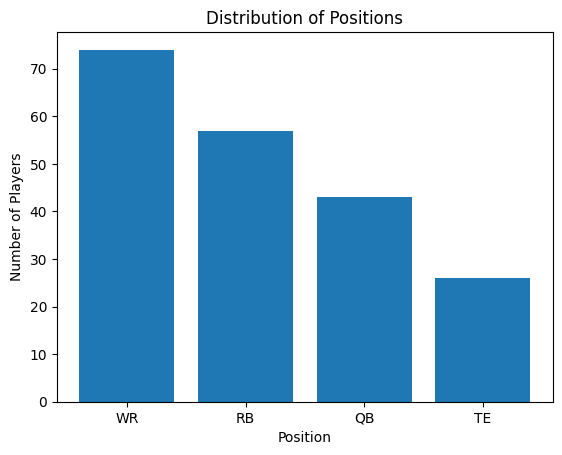

In [ ]:
# Plot the distribution of positions

# Count the number of players in each position group
position_counts = df['Position'].value_counts()

# Create a bar chart of the position group counts
plt.bar(position_counts.index, position_counts.values)
plt.xlabel('Position')
plt.ylabel('Number of Players')
plt.title('Distribution of Positions')
plt.show()

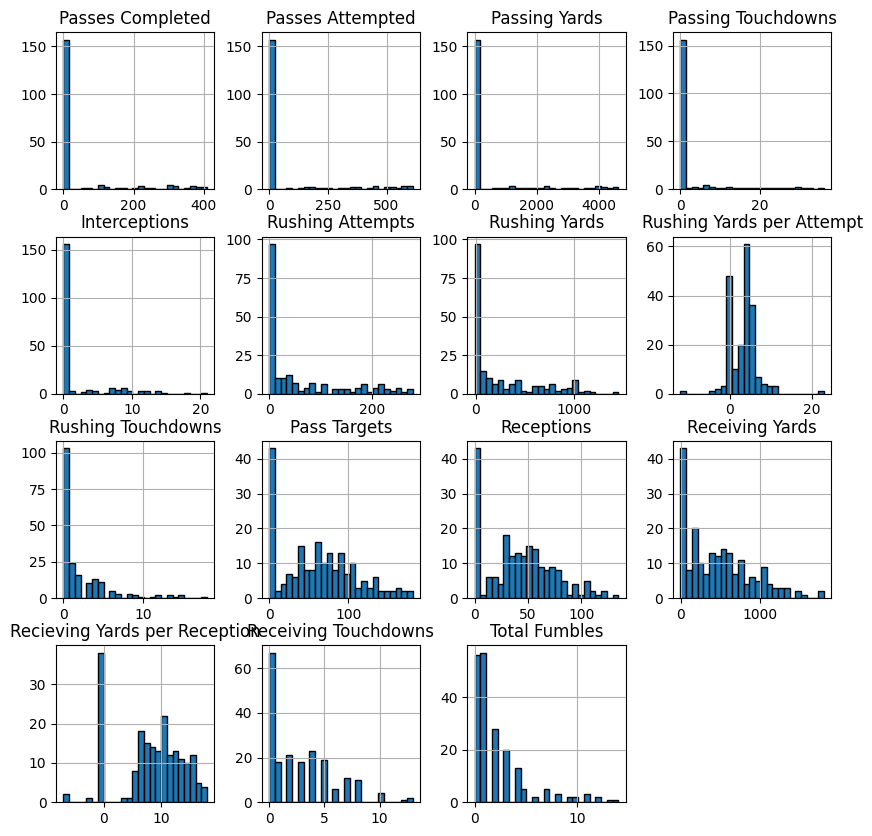

In [ ]:
# Create a histogram for each numeric feature
df.hist(figsize=(10, 10), bins=25, edgecolor='black')
plt.show()

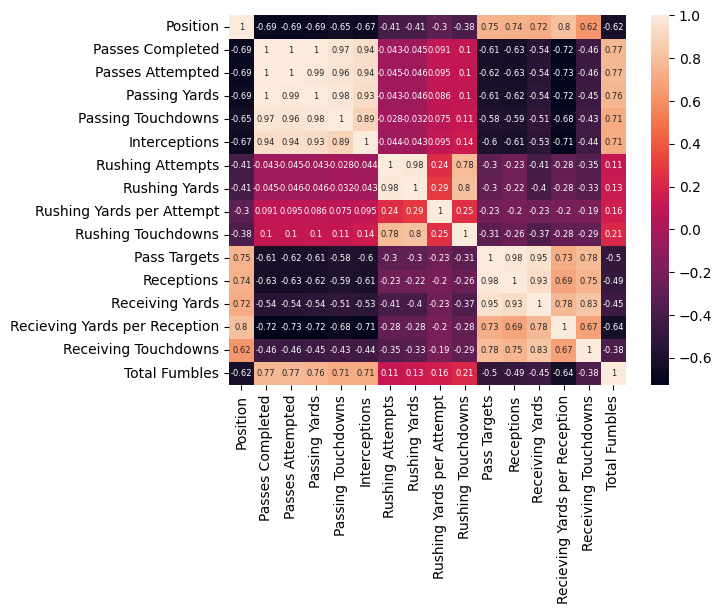

In [ ]:
# Map position data to ints
mapping = {'QB': 0, 'RB': 1, 'WR': 2, 'TE': 3}
df['Position'] = df['Position'].map(mapping)

# Create a heatmap of the correlation matrix
sns.heatmap(df.corr(), annot=True, annot_kws={"size": 6})
plt.show()


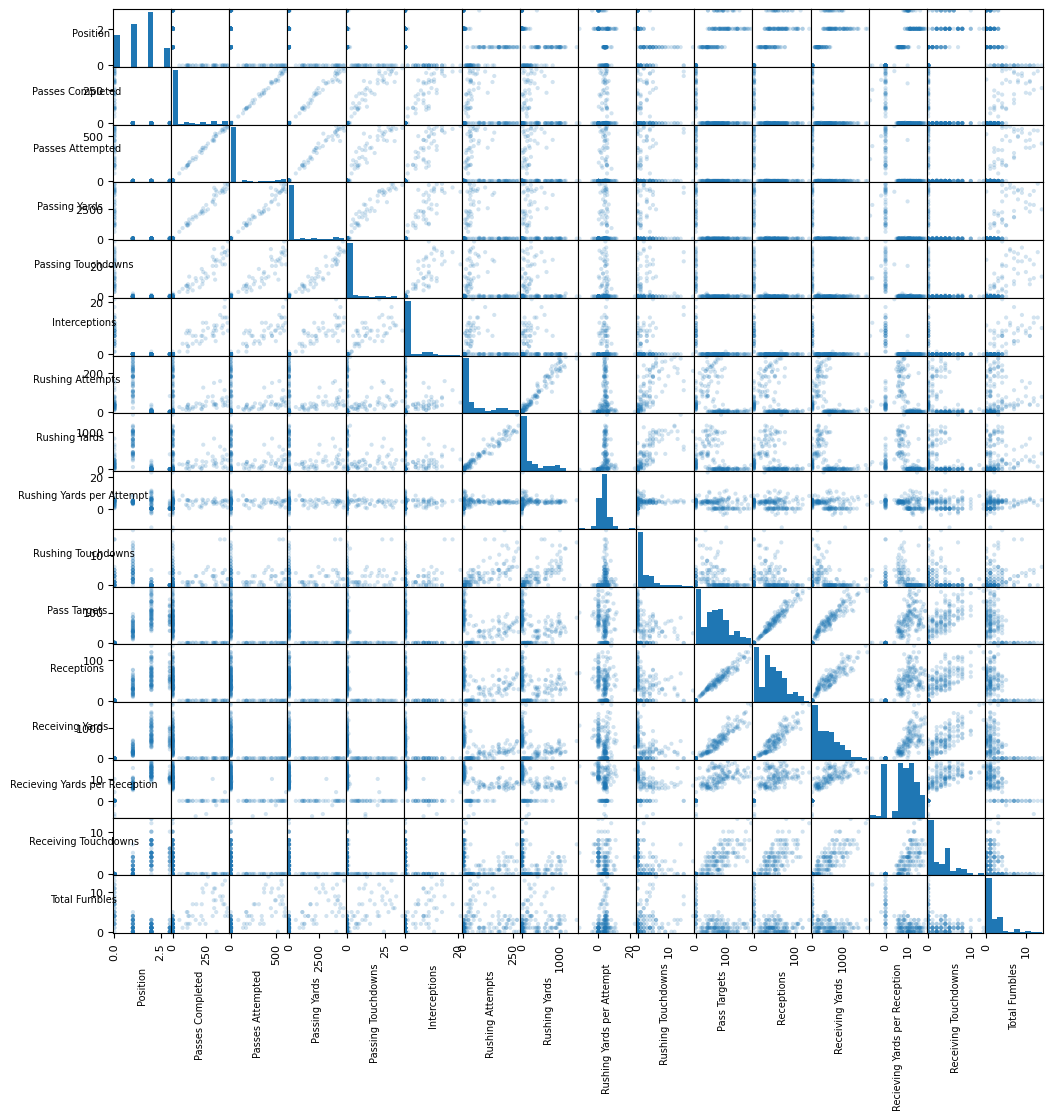

In [ ]:
# Create a scatter matrix

scatter_matrix = pd.plotting.scatter_matrix(df.select_dtypes(include=[np.number]), figsize=(12, 12), alpha=0.2)
for ax in scatter_matrix.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize = 7, rotation = 90)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 7, rotation = 0)
plt.show()


# 4.   Building and Training the Model
*   Split data into training, validation, and test






In [ ]:
# Shuffle data and split into training, validation, and test
train_data, validation_data, test_data = np.split(df.sample(frac=1, random_state=6942),
                                                  [int(0.7 * len(df)), int(0.9 * len(df))])


In [ ]:
# Separate target
X_train = train_data.drop("Position", axis=1)
y_train = train_data["Position"]
X_val = validation_data.drop("Position", axis=1)
y_val = validation_data["Position"]
X_test = test_data.drop("Position", axis=1)
y_test = test_data["Position"]

# Convert the datasets into DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
# Model parameters
params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'multi:softmax',
    'num_class': 4,
    'eval_metric': 'mlogloss'
}
num_rounds = 100

In [ ]:
# Train the model using the training dataset and evaluate it using the validation dataset
evallist = [(dval, 'eval'), (dtrain, 'train')]
bst = xgb.train(params, dtrain, num_rounds, evallist)

[0]	eval-mlogloss:1.24588	train-mlogloss:1.23037
[1]	eval-mlogloss:1.12974	train-mlogloss:1.10161


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[2]	eval-mlogloss:1.03299	train-mlogloss:0.99301
[3]	eval-mlogloss:0.94979	train-mlogloss:0.90002
[4]	eval-mlogloss:0.87845	train-mlogloss:0.81992
[5]	eval-mlogloss:0.81558	train-mlogloss:0.74900
[6]	eval-mlogloss:0.75751	train-mlogloss:0.68621
[7]	eval-mlogloss:0.70850	train-mlogloss:0.63096
[8]	eval-mlogloss:0.66389	train-mlogloss:0.58079
[9]	eval-mlogloss:0.62432	train-mlogloss:0.53660
[10]	eval-mlogloss:0.59074	train-mlogloss:0.49635
[11]	eval-mlogloss:0.55952	train-mlogloss:0.46089
[12]	eval-mlogloss:0.53234	train-mlogloss:0.42781
[13]	eval-mlogloss:0.50625	train-mlogloss:0.39767
[14]	eval-mlogloss:0.48552	train-mlogloss:0.37141
[15]	eval-mlogloss:0.46670	train-mlogloss:0.34715
[16]	eval-mlogloss:0.45126	train-mlogloss:0.32574
[17]	eval-mlogloss:0.43573	train-mlogloss:0.30610
[18]	eval-mlogloss:0.42159	train-mlogloss:0.28750
[19]	eval-mlogloss:0.41032	train-mlogloss:0.27089
[20]	eval-mlogloss:0.40247	train-mlogloss:0.25491
[21]	eval-mlogloss:0.39497	train-mlogloss:0.24012
[22]	eva

# 5.   Testing the Model



In [ ]:
# Implementing early stopping

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,  # Set to a high number intentionally; training may stop much earlier
    evals=[(dval, "eval")],
    early_stopping_rounds=10  # Stops after 10 rounds of no improvement on the eval dataset
)

print(f"Best iteration: {bst.best_iteration}")

[0]	eval-mlogloss:1.24588
[1]	eval-mlogloss:1.12974
[2]	eval-mlogloss:1.03299
[3]	eval-mlogloss:0.94979
[4]	eval-mlogloss:0.87845
[5]	eval-mlogloss:0.81558
[6]	eval-mlogloss:0.75751
[7]	eval-mlogloss:0.70850
[8]	eval-mlogloss:0.66389
[9]	eval-mlogloss:0.62432
[10]	eval-mlogloss:0.59074
[11]	eval-mlogloss:0.55952
[12]	eval-mlogloss:0.53234
[13]	eval-mlogloss:0.50625
[14]	eval-mlogloss:0.48552
[15]	eval-mlogloss:0.46670
[16]	eval-mlogloss:0.45126
[17]	eval-mlogloss:0.43573
[18]	eval-mlogloss:0.42159
[19]	eval-mlogloss:0.41032
[20]	eval-mlogloss:0.40247
[21]	eval-mlogloss:0.39497
[22]	eval-mlogloss:0.38719
[23]	eval-mlogloss:0.38220
[24]	eval-mlogloss:0.37325
[25]	eval-mlogloss:0.36884
[26]	eval-mlogloss:0.36316
[27]	eval-mlogloss:0.35891
[28]	eval-mlogloss:0.35691
[29]	eval-mlogloss:0.35216
[30]	eval-mlogloss:0.34879
[31]	eval-mlogloss:0.34550
[32]	eval-mlogloss:0.34199
[33]	eval-mlogloss:0.34157
[34]	eval-mlogloss:0.33858
[35]	eval-mlogloss:0.33490
[36]	eval-mlogloss:0.33398
[37]	eval-m

In [ ]:
# prompt: create a test df

test_df = pd.DataFrame()

In [ ]:
# Add a new observation to test_df with parameters we can change

# Brock Purdy (QB)
new_observation = {
    'Position': 0,
    'Passes Completed': 308,
    'Passes Attempted': 444,
    'Passing Yards': 4280,
    'Passing Touchdowns': 31,
    'Interceptions': 11,
    'Rushing Attempts': 39,
    'Rushing Yards': 144,
    'Rushing Yards per Attempt': 3.69,
    'Rushing Touchdowns': 2,
    'Pass Targets': 0,
    'Receptions': 0,
    'Receiving Yards': 0,
    'Recieving Yards per Reception': 0,
    'Receiving Touchdowns': 0,
    'Total Fumbles': 6,
}

# Use the concat() function to add a new observation
new_observation_df = pd.DataFrame([new_observation]) # Convert dictionary to DataFrame
test_df = pd.concat([test_df, new_observation_df], ignore_index=True)
test_df

,Position,Passes Completed,Passes Attempted,Passing Yards,Passing Touchdowns,Interceptions,Rushing Attempts,Rushing Yards,Rushing Yards per Attempt,Rushing Touchdowns,Pass Targets,Receptions,Receiving Yards,Recieving Yards per Reception,Receiving Touchdowns,Total Fumbles
0,0,308,444,4280,31,11,39,144,3.69,2,0,0,0,0,0,6


In [ ]:
x_single = test_df.drop("Position", axis=1)
y_single = test_df["Position"]

In [ ]:
# Test the model from the best iteration on the new observation

new_observation_dmatrix = xgb.DMatrix(x_single)
y_pred = bst.predict(new_observation_dmatrix)  # Remove ntree_limit

y_pred_numerical = int(y_pred[0])

# Reverse map ints to position data
reverse_mapping = {0: 'QB', 1: 'RB', 2: 'WR', 3: 'TE'}

print( "The model predicts that the player with the given stats is a:")
print(reverse_mapping[y_pred_numerical])


The model predicts that the player with the given stats is a:
QB


In [ ]:
test_df = pd.DataFrame()

# Luke Musgrave (TE) (outside top 200 - not in og dataset)
new_observation = {
    'Position': 3,
    'Passes Completed': 0,
    'Passes Attempted': 0,
    'Passing Yards': 0,
    'Passing Touchdowns': 0,
    'Interceptions': 0,
    'Rushing Attempts': 0,
    'Rushing Yards': 0,
    'Rushing Yards per Attempt': 0,
    'Rushing Touchdowns': 0,
    'Pass Targets': 46,
    'Receptions': 34,
    'Receiving Yards': 352,
    'Recieving Yards per Reception': 10.35,
    'Receiving Touchdowns': 1,
    'Total Fumbles': 0,
}

# Use the concat() function to add a new observation
new_observation_df = pd.DataFrame([new_observation]) # Convert dictionary to DataFrame
test_df = pd.concat([test_df, new_observation_df], ignore_index=True)
test_df

,Position,Passes Completed,Passes Attempted,Passing Yards,Passing Touchdowns,Interceptions,Rushing Attempts,Rushing Yards,Rushing Yards per Attempt,Rushing Touchdowns,Pass Targets,Receptions,Receiving Yards,Recieving Yards per Reception,Receiving Touchdowns,Total Fumbles
0,3,0,0,0,0,0,0,0,0,0,46,34,352,10.35,1,0


In [ ]:
x_single = test_df.drop("Position", axis=1)
y_single = test_df["Position"]

# Test the model from the best iteration on the new observation

new_observation_dmatrix = xgb.DMatrix(x_single)
y_pred = bst.predict(new_observation_dmatrix)

y_pred_numerical = int(y_pred[0])

# Reverse map ints to position data
reverse_mapping = {0: 'QB', 1: 'RB', 2: 'WR', 3: 'TE'}

print( "The model predicts that the player with the given stats is a:")
print(reverse_mapping[y_pred_numerical])

The model predicts that the player with the given stats is a:
TE


This, although only one data point and therefore not a good sample size, is promising for the model's accuracy. I originally hypothesized that the biggest struggle in differentiation would be between the tight end and wide reciever role, due to their similar nature.

# Credits:


1.   Data Science with Python: Foundations of Machine Learning
by Amber Israelsen (Course on PluralSight) https://app.pluralsight.com/library/courses/data-science-python-foundations-machine-learning/table-of-contents
2.   Webscraping NFL Data with Python to CSV by Prime DFS on YouTube https://www.youtube.com/watch?v=XNhOs2bVHMo&ab_channel=PrimeDFS, https://github.com/pvicks585/NFL-WebScrape
3.   Answer by piRSquared on Stack Overflow https://stackoverflow.com/questions/43217174/how-can-the-sizes-and-rotations-of-text-of-a-pandas-scatter-matrix-be-set


